In [1]:
import os
# 0 = all logs, 1 = filter out INFO, 2 = filter out WARNING, 3 = filter out ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# --- 1. GPU config ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.debugging.set_log_device_placement(False)
else:
    print("No GPU found!")

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# Load data

In [6]:
image_folder_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/'
caption_path = '/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv'

In [7]:
data = pd.read_csv(caption_path, delimiter='|')
data

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ov...
158911,998845445.jpg,1,"A young man hanging over the side of a boat ,..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue an...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with ..."


In [8]:
data.columns

Index(['image_name', ' comment_number', ' comment'], dtype='object')

In [9]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size)) 
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(os.path.join(image_folder_path,temp_df.image_name[i]))
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df[' comment'][i], 20)))
        plt.axis("off")

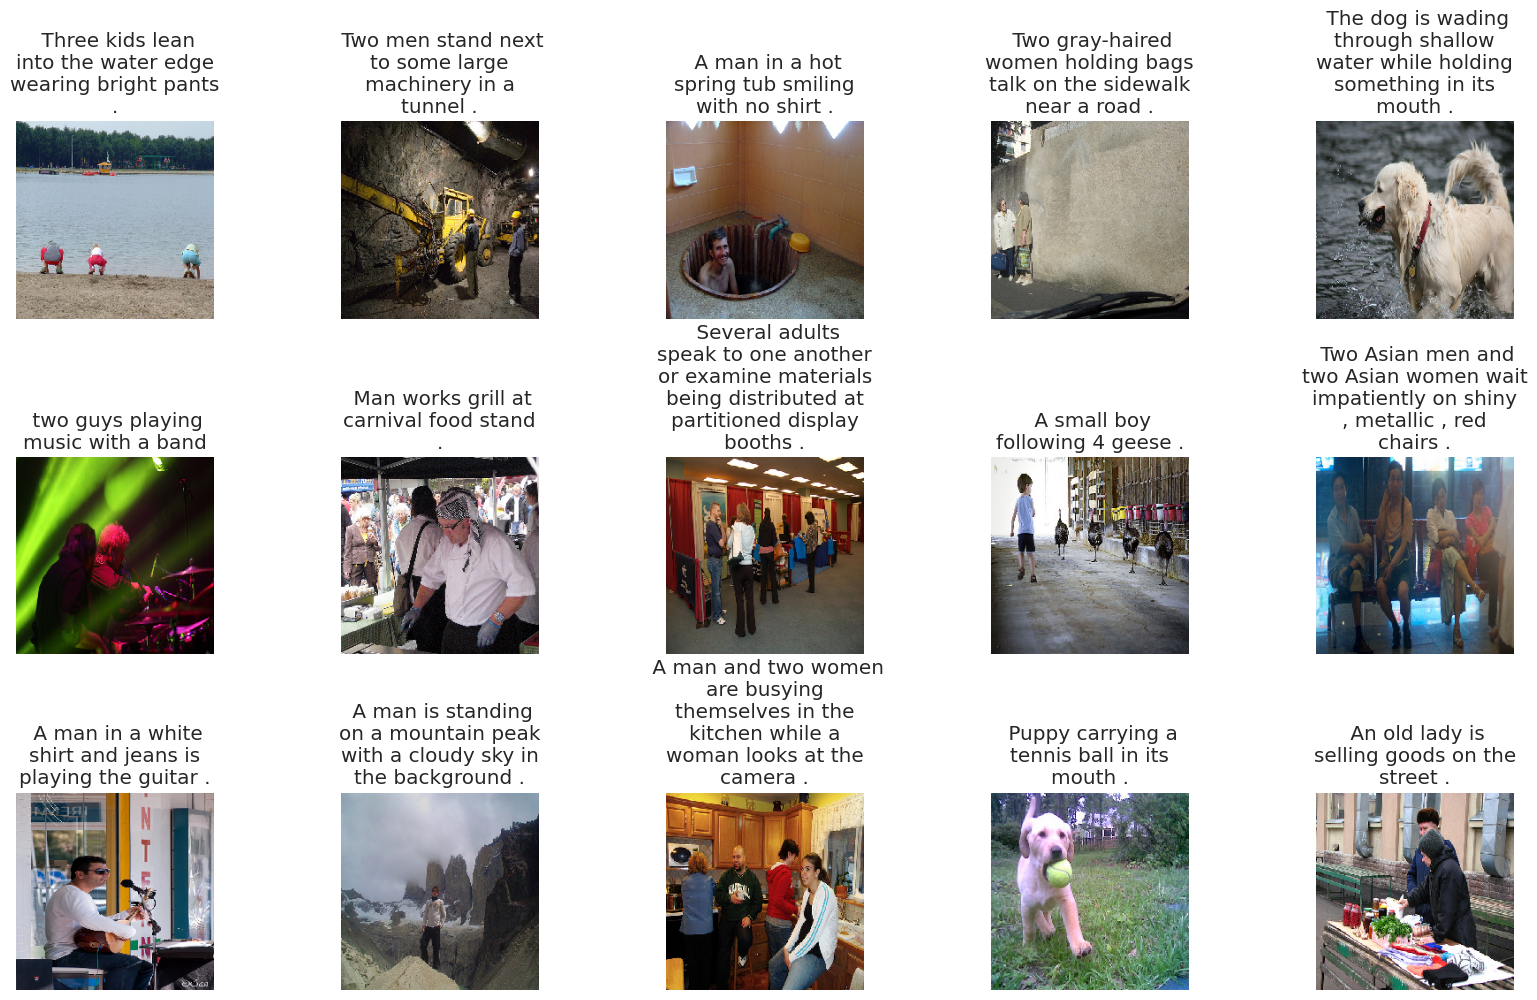

In [10]:
display_images(data.sample(15))

In [11]:
import re

In [12]:
def text_preprocessing(df, col=" comment"):
    # 1) Clone DataFrame để không thay đổi gốc
    df = df.copy()

    # 2) Fill NaN và ép về str
    df[col] = df[col].fillna("").astype(str)

    # 3) Chuyển về chữ thường
    df[col] = df[col].str.lower()

    # 4) Loại bỏ ký tự không phải chữ cái (giữ khoảng trắng)
    df[col] = df[col].str.replace(r'[^a-z\s]', ' ', regex=True)

    # 5) Ghép nhiều khoảng trắng thành 1 và strip
    df[col] = df[col].str.replace(r'\s+', ' ', regex=True).str.strip()

    # 6) Thêm startseq/endseq
    df[col] = df[col].apply(lambda s: f"startseq {s} endseq")

    return df

In [13]:
data = text_preprocessing(data)
captions = data[' comment'].tolist()
captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in a yard endseq',
 'startseq a man in a blue shirt standing in a garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating a giant pulley system endseq',
 'startseq workers look down from up above on a piece of equipment endseq',
 'startseq two men working on a machine wearing hard hats endseq',
 'startseq four men on top of a tall structure endseq',
 'startseq three men on a large rig endseq']

# Tokenizer

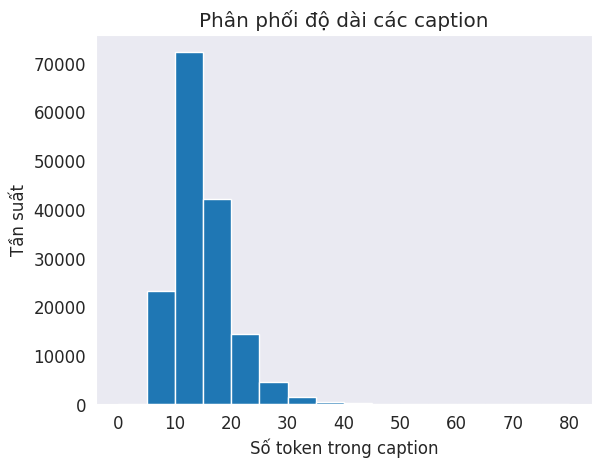

Độ dài tối đa       : 80
Percentile 90%      : 21
Percentile 95%      : 24
Percentile 99%      : 32


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Giả sử bạn đã có list captions (mỗi phần tử là một chuỗi đã add 'startseq'/'endseq')
lengths = [len(c.split()) for c in captions]

# 1) Vẽ histogram
plt.hist(lengths, bins=range(0, max(lengths)+5, 5))
plt.xlabel('Số token trong caption')
plt.ylabel('Tần suất')
plt.title('Phân phối độ dài các caption')
plt.show()

# 2) In ra thống kê
print(f"Độ dài tối đa       : {max(lengths)}")
print(f"Percentile 90%      : {int(np.percentile(lengths, 90))}")
print(f"Percentile 95%      : {int(np.percentile(lengths, 95))}")
print(f"Percentile 99%      : {int(np.percentile(lengths, 99))}")


In [15]:
# 2.1 Tokenizer có OOV + giữ token đặc biệt luôn có chỉ số cố định
tokenizer = Tokenizer(oov_token="<unk>", filters='!"#$%&()*+.,/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(captions)
# đảm bảo <pad> = 0
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

vocab_size = len(tokenizer.word_index) + 1
max_length = 25

In [16]:
print('Vocab Size: ',vocab_size)

Vocab Size:  18084


In [17]:
tokenizer.texts_to_sequences (["startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq"])[0]

[3, 14, 23, 328, 12, 2032, 90, 189, 18, 64, 162, 25, 326, 73, 5, 6, 491, 4]

In [18]:
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json

# ── LƯU ──────────────────────────────
token_json = tokenizer.to_json()      # string JSON
with open("tokenizer.json", "w", encoding="utf-8") as f:
    f.write(token_json)

In [19]:
# Đọc chuỗi JSON từ file
with open("tokenizer.json", "r", encoding="utf-8") as f:
    json_str = f.read()

# Tạo lại tokenizer từ chuỗi JSON
tokenizer = tokenizer_from_json(json_str)

In [20]:
tokenizer.texts_to_sequences (["startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq"])[0]

[3, 14, 23, 328, 12, 2032, 90, 189, 18, 64, 162, 25, 326, 73, 5, 6, 491, 4]

# Train Test Split

In [21]:
import random

In [22]:
images = data['image_name'].unique().tolist()
nimages = len(images)
random.seed(42)
random.shuffle(images)
split_index = round(0.9*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image_name'].isin(train_images)]
test = data[data['image_name'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [23]:
train

,image_name,comment_number,comment
0,1000092795.jpg,0,startseq two young guys with shaggy hair look ...
1,1000092795.jpg,1,startseq two young white males are outside nea...
2,1000092795.jpg,2,startseq two men in green shirts are standing ...
3,1000092795.jpg,3,startseq a man in a blue shirt standing in a g...
4,1000092795.jpg,4,startseq two friends enjoy time spent together...
...,...,...,...
143020,998845445.jpg,0,startseq a man in shorts and a hawaiian shirt ...
143021,998845445.jpg,1,startseq a young man hanging over the side of ...
143022,998845445.jpg,2,startseq a man is leaning off of the side of a...
143023,998845445.jpg,3,startseq a man riding a small boat in a harbor...


In [24]:
test

,image_name,comment_number,comment
0,1001896054.jpg,0,startseq a man with reflective safety clothes ...
1,1001896054.jpg,1,startseq john deere tractors cruises down a st...
2,1001896054.jpg,2,startseq a man in a neon green and orange unif...
3,1001896054.jpg,3,startseq a man in a tractor wearing headphones...
4,1001896054.jpg,4,startseq a man driving a john deere tractor on...
...,...,...,...
15885,996962407.jpg,0,startseq a man with a wheelbarrow is standing ...
15886,996962407.jpg,1,startseq a man in a silver rain poncho standin...
15887,996962407.jpg,2,startseq a man in a silver raincoat standing o...
15888,996962407.jpg,3,startseq a man in a raincoat stands outside a ...


# Load Features

In [25]:
import pickle
with open('/kaggle/input/extract-features-flick30k-by-inceptionv3/features_flick30k.pkl', 'rb') as f:
    features = pickle.load(f)

In [26]:
preview = []
for fname, feat in list(features.items())[:10]:  # lấy 10 dòng
    preview.append({
        'filename': fname,
        'shape': feat.shape,
    })

df_preview = pd.DataFrame(preview)
print(df_preview)

         filename       shape
0  1000092795.jpg  (64, 2048)
1    10002456.jpg  (64, 2048)
2  1000268201.jpg  (64, 2048)
3  1000344755.jpg  (64, 2048)
4  1000366164.jpg  (64, 2048)
5  1000523639.jpg  (64, 2048)
6  1000919630.jpg  (64, 2048)
7    10010052.jpg  (64, 2048)
8  1001465944.jpg  (64, 2048)
9  1001545525.jpg  (64, 2048)


# Load data in Model

In [27]:
class CaptionDataLoader(Sequence):
    """
    Sequence data loader for Image Captioning.

    Yields:
      X = [img_feats, cap_input]  
         img_feats: (B, num_patches, feature_dim)  
         cap_input: (B, max_len)  
      y = cap_target  
         cap_target: (B, max_len)  — token ids shifted by one  
    """
    def __init__(self, df, img_col, cap_col,
                 tokenizer, features_dict,
                 max_len, batch_size=64, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.img_col = img_col
        self.cap_col = cap_col
        self.tokenizer = tokenizer
        self.features = features_dict
        self.max_len = max_len
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Precompute token sequences
        self.seqs = tokenizer.texts_to_sequences(self.df[self.cap_col])
        # Pad all sequences to max_len
        self.seqs = tf.keras.preprocessing.sequence.pad_sequences(
            self.seqs, maxlen=self.max_len, padding='post'
        )
        self.indices = np.arange(len(self.seqs))
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.indices) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        # Batch slice
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        B = len(batch_idx)

        # Prepare containers
        num_patches, feat_dim = next(iter(self.features.values())).shape
        img_batch = np.zeros((B, num_patches, feat_dim), dtype=np.float32)
        cap_in    = np.zeros((B, self.max_len), dtype=np.int32)
        cap_tar   = np.zeros((B, self.max_len), dtype=np.int32)

        for i, j in enumerate(batch_idx):
            # 1) load image features
            fname = os.path.basename(self.df.loc[j, self.img_col])
            img_batch[i] = self.features[fname]

            # 2) get full padded sequence
            seq = self.seqs[j]
            # input is full seq, target is shifted left by 1
            cap_in[i]  = seq
            cap_tar[i] = np.concatenate([seq[1:], [0]])  # shift and pad last

        return [img_batch, cap_in], cap_tar

# Model

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, callbacks

In [29]:
# ===== Custom Layers =====
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim)
        self.embed_dim = embed_dim
        self.sequence_length = sequence_length
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        x = self.token_embeddings(inputs)
        x *= self.embed_scale
        positions = tf.range(start=0, limit=seq_len, delta=1)
        pos_emb = self.position_embeddings(positions)
        return x + pos_emb[tf.newaxis, ...]

    def compute_mask(self, inputs, mask=None):
        return tf.not_equal(inputs, 0)

In [30]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=None, mask=None):
        # Self-attention
        attn_out = self.attn(query=inputs, value=inputs, key=inputs, attention_mask=mask)
        attn_out = self.dropout1(attn_out, training=training)
        out1 = self.norm1(inputs + attn_out)
        # Feed-forward
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out, training=training)
        return self.norm2(out1 + ffn_out)

In [31]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.self_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.cross_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.dropout3 = layers.Dropout(dropout_rate)

    def create_look_ahead_mask(self, seq_len):
        # allow positions <= current, mask future
        mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return tf.cast(mask, tf.bool)  # shape (seq_len, seq_len), tf.newaxis, ...]

    def call(self, x, enc_output, training=None, look_ahead_mask=None):
        # 1) Masked self-attention
        attn1 = self.self_attn(query=x, value=x, key=x, attention_mask=look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.norm1(x + attn1)
        # 2) Cross-attention (no mask needed for image)
        attn2 = self.cross_attn(query=out1, value=enc_output, key=enc_output)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.norm2(out1 + attn2)
        # 3) Feed-forward
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out, training=training)
        return self.norm3(out2 + ffn_out)

In [32]:
# ===== Build Model =====
def build_image_captioning_model(
    feature_dim, num_patches,
    vocab_size, max_len,
    num_layers=4,
    embed_dim=512, num_heads=8,
    ff_dim=2048, dropout_rate=0.1
):
    # image feature input & projection
    img_input = layers.Input(shape=(num_patches, feature_dim), name='img_input')
    proj = layers.Dense(embed_dim, activation='relu')(img_input)
    # learned patch positional embedding
    pos_layer = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)
    positions = tf.range(num_patches)
    proj += pos_layer(positions)[tf.newaxis, ...]
    # encoder
    x_enc = proj
    for _ in range(num_layers):
        x_enc = TransformerEncoderBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x_enc, training=True)
    enc_output = x_enc

    # caption input & embedding
    cap_input = layers.Input(shape=(max_len,), name='cap_input')
    cap_emb = PositionalEmbedding(max_len, vocab_size, embed_dim)(cap_input)
    look_mask = TransformerDecoderBlock(embed_dim, num_heads, ff_dim).create_look_ahead_mask(max_len)
    # decoder
    x_dec = cap_emb
    for _ in range(num_layers):
        x_dec = TransformerDecoderBlock(embed_dim, num_heads, ff_dim, dropout_rate)(
            x_dec, enc_output, training=True, look_ahead_mask=look_mask)
    # output
    outputs = layers.Dense(vocab_size, activation='softmax')(x_dec)
    return Model(inputs=[img_input, cap_input], outputs=outputs)

In [33]:
# ===== Example =====
FEATURE_DIM = 2048
NUM_PATCHES = 64
VOCAB_SIZE  = vocab_size
MAX_LEN     = max_length
model = build_image_captioning_model(
    FEATURE_DIM, NUM_PATCHES,
    VOCAB_SIZE, MAX_LEN,
    num_layers=2, embed_dim=512,
    num_heads=4, ff_dim=2048,
    dropout_rate=0.1
)
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 64, 2048)]   0           []                               
                                                                                                  
 dense (Dense)                  (None, 64, 512)      1049088     ['img_input[0][0]']              
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 64, 512)     0           ['dense[0][0]']                  
 da)                                                                                              
                                                                                                  
 cap_input (InputLayer)         [(None, 25)]         0           []                           

In [34]:
from keras.utils.vis_utils import plot_model

# Vẽ và lưu ra file PNG
plot_model(
    model,
    to_file="model_architecture.png",
    show_shapes=True,
    show_layer_names=True
)
print("Saved model plot to model_architecture.png")


Saved model plot to model_architecture.png


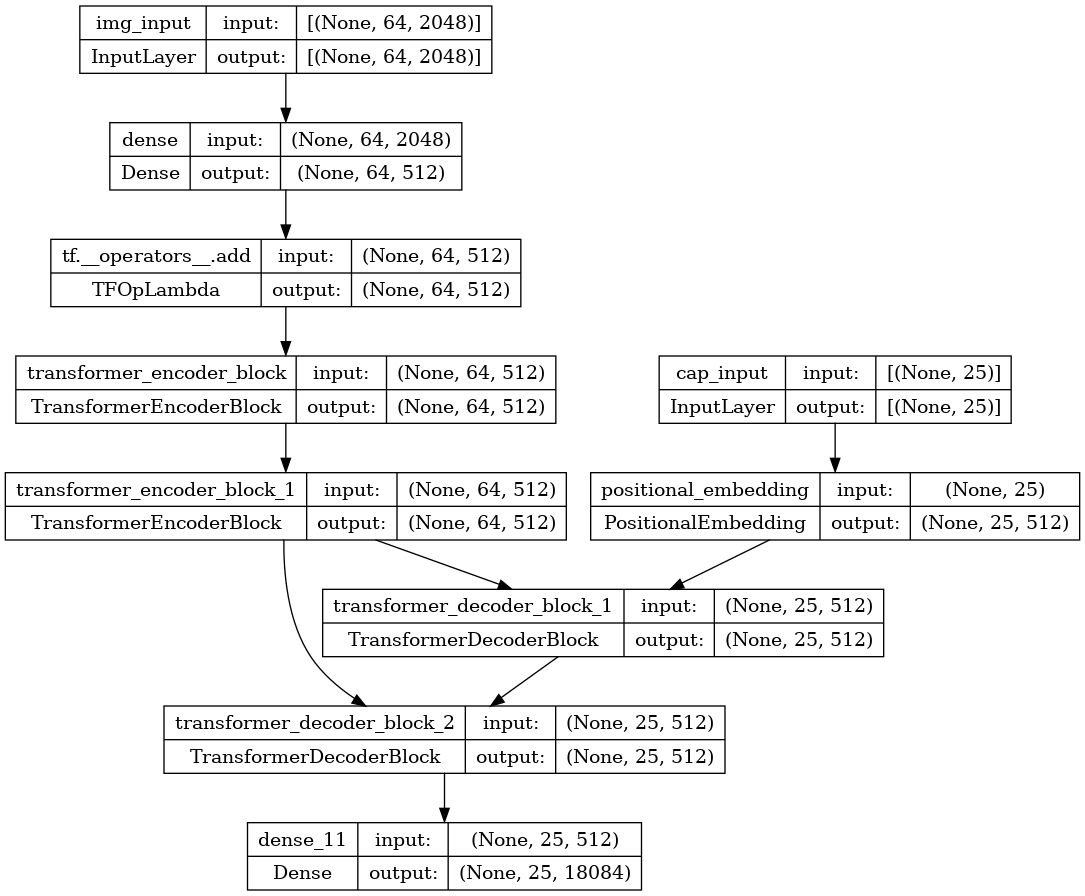

In [35]:
from IPython.display import Image
Image("model_architecture.png")

# Create Loader

In [36]:
# 1) Tạo loader cho train và validation
train_loader = CaptionDataLoader(
    df=train,
    img_col='image_name',
    cap_col=' comment',
    tokenizer=tokenizer,
    features_dict=features,
    max_len=max_length,
    batch_size=64,
    shuffle=True
)

val_loader = CaptionDataLoader(
    df=test,
    img_col='image_name',
    cap_col=' comment',
    tokenizer=tokenizer,
    features_dict=features,
    max_len=max_length,
    batch_size=64,
    shuffle=False
)

In [37]:
model_name = "caption_resnet101_lstm.keras"     # đặt tên lại cho sát kiến trúc

checkpoint = ModelCheckpoint(
    filepath=model_name,            # lưu dưới dạng SavedModel *.keras
    monitor="val_loss",             # giữ best theo loss (hoặc metric tuỳ bạn)
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5,          # dừng sau 3 epoch không tiến bộ
    min_delta=0.0,
    restore_best_weights=True,
    verbose=1
)


# Train Model

In [38]:
# 2) Train + đánh giá
model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=20,
    callbacks=[checkpoint,earlystopping]
)

Epoch 1/20
2235/2235 [==============================] - ETA: 0s - loss: 2.1450 - sparse_categorical_accuracy: 0.6450
Epoch 1: val_loss improved from inf to 1.74736, saving model to caption_resnet101_lstm.keras
2235/2235 [==============================] - 767s 335ms/step - loss: 2.1450 - sparse_categorical_accuracy: 0.6450 - val_loss: 1.7474 - val_sparse_categorical_accuracy: 0.6749
Epoch 2/20
2235/2235 [==============================] - ETA: 0s - loss: 1.6199 - sparse_categorical_accuracy: 0.6843
Epoch 2: val_loss improved from 1.74736 to 1.61208, saving model to caption_resnet101_lstm.keras
2235/2235 [==============================] - 747s 334ms/step - loss: 1.6199 - sparse_categorical_accuracy: 0.6843 - val_loss: 1.6121 - val_sparse_categorical_accuracy: 0.6864
Epoch 3/20
2235/2235 [==============================] - ETA: 0s - loss: 1.4518 - sparse_categorical_accuracy: 0.7020
Epoch 3: val_loss improved from 1.61208 to 1.57430, saving model to caption_resnet101_lstm.keras
2235/2235 [=

# Gen caption

In [39]:
def greedy_decode(model, feature, tokenizer, max_len):
    """
    Generate caption for an image feature using greedy search.
    feature: np.array shape (1, num_patches, feature_dim)
    returns: generated caption string
    """
    in_seq = [tokenizer.word_index['startseq']]
    for i in range(max_len):
        seq_padded = pad_sequences([in_seq], maxlen=max_len, padding='post')
        
        # Predict next token probabilities
        yhat = model.predict([feature, seq_padded], verbose=0)
        probs = yhat[0, len(in_seq)-1]
        next_token = np.argmax(probs)
        in_seq.append(int(next_token))
        print(in_seq)
        if next_token == tokenizer.word_index.get('endseq'):
            break
    # convert tokens to words
    words = [tokenizer.index_word[idx] for idx in in_seq if idx not in (tokenizer.word_index['startseq'], tokenizer.word_index['endseq'], 0)]
    return ' '.join(words)

In [40]:
def beam_search_decode(model, feature, tokenizer, max_len, beam_width=3):
    """
    Generate caption for an image feature using beam search.
    feature: np.array shape (1, num_patches, feature_dim)
    returns: best caption string
    """
    start = tokenizer.word_index['startseq']
    end = tokenizer.word_index['endseq']
    # Initialize sequences [(seq, score)]
    sequences = [([start], 0.0)]
    for _ in range(max_len):
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == end:
                # already finished
                all_candidates.append((seq, score))
                continue
            seq_padded = pad_sequences([seq], maxlen=max_len, padding='post')
            yhat = model.predict([feature, seq_padded], verbose=0)
            probs = yhat[0, len(seq)-1]
            # select top beam_width candidates
            top_tokens = np.argsort(probs)[-beam_width:]
            for token in top_tokens:
                cand_seq = seq + [int(token)]
                cand_score = score - np.log(probs[token] + 1e-10)
                all_candidates.append((cand_seq, cand_score))
        # order by score
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]
    # choose best sequence
    best_seq = sequences[0][0]
    # convert tokens to words
    words = [tokenizer.index_word[idx] for idx in best_seq if idx not in (start, end, 0)]
    return ' '.join(words)

# Eval On Test

In [41]:
from nltk.translate.bleu_score import corpus_bleu

# 1) Chuẩn bị danh sách ảnh và ground‐truth captions
image_ids = test['image_name'].unique().tolist()[:2]

# Mỗi phần tử của refs là 1 list các reference captions (tách token) cho 1 ảnh
refs = []
for img in image_ids:
    caps = test[test['image_name'] == img][' comment'].tolist()
    # Loại bỏ startseq/endseq và split
    caps_tok = [cap.replace('startseq ', '').replace(' endseq', '').split() for cap in caps]
    refs.append(caps_tok)

# 2) Sinh caption cho mỗi ảnh
hyp_greedy = []
hyp_beam   = []
for img in image_ids:
    # Lấy feature và reshape thành (1, num_patches, feat_dim)
    feat = features[os.path.basename(img)][None, ...]
    
    # Greedy
    cap_g = greedy_decode(model, feat, tokenizer, max_length)
    hyp_greedy.append(cap_g.split())
    
    # Beam Search
    cap_b = beam_search_decode(model, feat, tokenizer, max_length, beam_width=5)
    hyp_beam.append(cap_b.split())

# 3) Tính BLEU-4
bleu_greedy = corpus_bleu(refs, hyp_greedy, weights=(0.25,0.25,0.25,0.25))
bleu_beam   = corpus_bleu(refs, hyp_beam,   weights=(0.25,0.25,0.25,0.25))

print(f"BLEU-4 (Greedy)    = {bleu_greedy:.4f}")
print(f"BLEU-4 (Beam, k=5) = {bleu_beam:.4f}")

[3, 2]
[3, 2, 9]
[3, 2, 9, 10]
[3, 2, 9, 10, 78]
[3, 2, 9, 10, 78, 2]
[3, 2, 9, 10, 78, 2, 1053]
[3, 2, 9, 10, 78, 2, 1053, 4]
[3, 2]
[3, 2, 9]
[3, 2, 9, 30]
[3, 2, 9, 30, 5]
[3, 2, 9, 30, 5, 2]
[3, 2, 9, 30, 5, 2, 240]
[3, 2, 9, 30, 5, 2, 240, 12]
[3, 2, 9, 30, 5, 2, 240, 12, 2]
[3, 2, 9, 30, 5, 2, 240, 12, 2, 240]
[3, 2, 9, 30, 5, 2, 240, 12, 2, 240, 5]
[3, 2, 9, 30, 5, 2, 240, 12, 2, 240, 5, 39]
[3, 2, 9, 30, 5, 2, 240, 12, 2, 240, 5, 39, 11]
[3, 2, 9, 30, 5, 2, 240, 12, 2, 240, 5, 39, 11, 126]
[3, 2, 9, 30, 5, 2, 240, 12, 2, 240, 5, 39, 11, 126, 4]
BLEU-4 (Greedy)    = 0.2757
BLEU-4 (Beam, k=5) = 0.2587


In [42]:
feat = features[next(iter(features))]
print(feat.shape)

(64, 2048)


In [43]:
hyp_greedy

[['a', 'man', 'is', 'riding', 'a', 'tractor'],
 ['a',
  'man',
  'sitting',
  'in',
  'a',
  'chair',
  'with',
  'a',
  'chair',
  'in',
  'front',
  'of',
  'him']]

In [44]:
print("startseq id =", tokenizer.word_index.get('startseq'))
print("endseq   id =", tokenizer.word_index.get('endseq'))

startseq id = 3
endseq   id = 4


In [45]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def greedy_decode_debug(model, feature, tokenizer, max_len):
    start_id = tokenizer.word_index['startseq']
    end_id   = tokenizer.word_index['endseq']
    in_seq = [start_id]
    print("Start decoding — startseq id:", start_id)

    for i in range(max_len):
        seq_pad = pad_sequences([in_seq], maxlen=max_len, padding='post')
        yhat = model.predict([feature, seq_pad], verbose=0)
        # yhat shape: (1, max_len, vocab_size)
        probs = yhat[0, len(in_seq)-1]       # xác suất của token tại bước này
        next_id = int(np.argmax(probs))
        word = tokenizer.index_word.get(next_id, "<unk>")
        print(f" Step {i+1:2d}: predict id={next_id:4d} -> '{word}'")
        in_seq.append(next_id)
        if next_id == end_id:
            print("  ↳ Reached endseq, stopping.")
            break

    # Lọc ra caption (loại startseq, endseq, pad)
    caption = [tokenizer.index_word[id] 
               for id in in_seq 
               if id not in (start_id, end_id, 0)]
    print("Decoded token ids:", in_seq)
    print("Final caption     :", " ".join(caption))
    return " ".join(caption)

# Lấy feature cho một ảnh test
feat = features['10002456.jpg'][None, ...]  # shape (1,64,2048)
_ = greedy_decode_debug(model, feat, tokenizer, max_length)


Start decoding — startseq id: 3
 Step  1: predict id=  14 -> 'two'
 Step  2: predict id=  31 -> 'men'
 Step  3: predict id=  15 -> 'are'
 Step  4: predict id= 115 -> 'working'
 Step  5: predict id=   7 -> 'on'
 Step  6: predict id=   2 -> 'a'
 Step  7: predict id= 190 -> 'construction'
 Step  8: predict id= 907 -> 'project'
 Step  9: predict id=   4 -> 'endseq'
  ↳ Reached endseq, stopping.
Decoded token ids: [3, 14, 31, 15, 115, 7, 2, 190, 907, 4]
Final caption     : two men are working on a construction project


In [46]:
# Đếm số caption trống (chỉ startseq endseq)
lens = train[' comment'].str.split().str.len()
print("Total captions:", len(lens))
print("Empty captions:", (lens == 2).sum())
print("Percent empty:", (lens == 2).mean())

Total captions: 143025
Empty captions: 1
Percent empty: 6.991784653032687e-06
